In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import sys
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import glob
import random
from torch.autograd import Variable

sys.path.insert(1, './code/')
from models import Create_nets
from optimizer import Get_loss_func
from utils import ReplayBuffer, LambdaLR, sample_images

In [2]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Using model epoch 10 from Exp0

In [4]:
class Options:
    def __init__(self, **opts):
        self.__dict__.update(opts)
        
opts = {'exp_name': 'assets/Exp0',
        'epoch_start': 10,
        'data_root': './datasets/',
        'dataset_name': 'photo2vangogh',
        'batch_size': 1,
        'lr': 0.0002,
        'b1': 0.5,
        'b2': 0.999,
        'decay_epoch': 8,
        'n_cpu': 4,
        'img_height': 256,
        'img_width': 256,
        'input_nc_A': 3,
        'input_nc_B': 3,
        'sample_interval': 200,
        'checkpoint_interval': 1,
        'n_residual_blocks': 9,
        'n_D_layers': 4,
        'lambda_cyc': 10,
        'lambda_id': 0.5,
        'pool_size': 50,
        'img_result_dir': 'results',
        'model_result_dir': 'saved_models'}

args = Options(**opts)

In [5]:
class ImageDataset(Dataset):
    def __init__(self, args, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.args = args
        self.unaligned = unaligned
        self.files_X = sorted(glob.glob(os.path.join(root, '%sA' % mode) + '/*.*'))
        self.files_Y = sorted(glob.glob(os.path.join(root, '%sB' % mode) + '/*.*'))
        self.real_X = None
        self.real_Y = None

    def __getitem__(self, index):

        img_X = Image.open(self.files_X[index % len(self.files_X)])
        if self.unaligned:
            img_Y = Image.open(self.files_Y[random.randint(0, len(self.files_Y)-1)])
        else:
            img_Y = Image.open(self.files_Y[index % len(self.files_Y)] )

        self.real_X = self.transform(img_X)
        self.real_Y = self.transform(img_Y)
        
        trans = transforms.Compose([transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
        
        img_X = trans(self.real_X)
        img_Y = trans(self.real_Y)

        if self.args.input_nc_A == 1:
            img_X = img_X.convert('L')

        if self.args.input_nc_B == 1:
            img_Y = img_Y.convert('L')

        return {'X': img_X, 'Y': img_Y}
    
    def getReal(self, index):
        img = Image.open(self.files_X[index % len(self.files_X)])
        img = self.transform(img)
        return img

    def __len__(self):
        return max(len(self.files_X), len(self.files_Y))

In [6]:
transforms_ = [ transforms.Resize(int(args.img_height*1.12), Image.BICUBIC),
                transforms.CenterCrop((args.img_height, args.img_width)) ]

test_dataloader = DataLoader(ImageDataset(args, "%s/%s" % (args.data_root, args.dataset_name), transforms_=transforms_, unaligned=True,mode='test'),
                        batch_size=50, shuffle=False, num_workers=1, drop_last=True)

In [7]:
imgs = next(iter(test_dataloader))

In [8]:
G__AB, _, _, _ = Create_nets(args)

In [9]:
with torch.no_grad():
    real_X_A = Variable(imgs['X'].type(torch.FloatTensor).cuda())
    fake_X_B = G__AB(real_X_A)

Text(0.5, 1.0, 'Original Photo Sample 1')

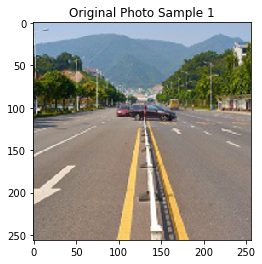

In [10]:
idx = 0
real_img = test_dataloader.dataset.getReal(idx)
plt.imshow(real_img)
plt.title("Original Photo Sample 1")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Transfered Picture Sample 1')

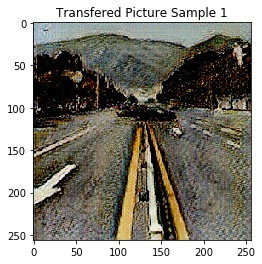

In [11]:
plt.imshow(fake_X_B.data[idx].cpu().permute(1, 2, 0).numpy())
plt.title("Transfered Picture Sample 1")

Text(0.5, 1.0, 'Original Photo Sample 2')

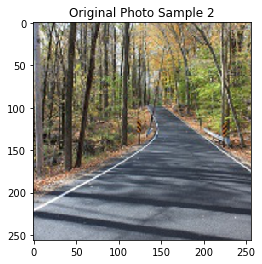

In [12]:
idx = 7
real_img = test_dataloader.dataset.getReal(idx)
plt.imshow(real_img)
plt.title("Original Photo Sample 2")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Transfered Picture Sample 2')

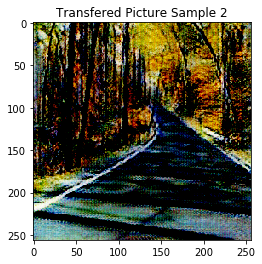

In [13]:
plt.imshow(fake_X_B.data[idx].cpu().permute(1, 2, 0))
plt.title("Transfered Picture Sample 2")